# Network analysis in Senegal

### Objectives
    1)	Use measures of road-based accessibility to identify road segments that, if rehabilitated, would improve agricultural market activities in Senegal, including during flood conditions.
    2)	Gain a better understanding of the accessibility, connectivity, and criticality of roads in Senegal in relationship to agricultural origins, processing & transfer sites, and markets.

To this end, the team will develop an accessibility model which measures the travel time from sites of agricultural production to their nearest populated areas, processing centers, and markets. 

### Datasets for analysis
#### ORIGIN
    1) agriculture: MapSPAM 2017. Measuring value in international dollars.
    2) agriculture: UMD Land Cover 2019 30m. Assign MapSPAM value onto land cover cropland class for more precise origin information.
    3) population: WorldPop 2020, UN-adjusted.
    4) settlement extent: GRID3 2020.
#### DESTINATION
    4) markets: derived from WorldPop 2020 and GRID3 2020 urban clusters.
    5) agricultural processing hubs: to be acquired.
#### TRAVEL ROUTE
    6) roads: OpenStreetMap, July 2021.
    7) elevation: 
#### OBSTACLE
    8) flood: FATHOM. 1-in-10, 20, and 50 year flood return periods. These are combined pluvial and fluvial (undefended) flood layers whereby whichever flood level was higher was retained.
#### INTERVENTION
    9) upcoming road projects: AGEROUTE interventions separate from the World Bank-financed project
    10) targeted road projects: critical road segments identified by this accessibility model's baseline outputs


### Model design
#### Basic formula: 
    (a) Off-road driving time from origin to closest road node
    +
    (b) Driving time from road node in (a) to a destination (closeness measured by road segments speeds)

#### Model origin & destination (OD) sets:
    A)	Travel time from an area that has agricultural value/potential to the nearest processing hub (if provided).
    B)	Travel time from an area that has agricultural value/potential to the nearest larger settlement, (“larger” settlement identified using a case-appropriate population metric to be determined).
    C)	Travel time from an area that has agricultural value/potential to the nearest market.
    D)	Travel time from all settlements to the nearest market.
    E)	Travel time from larger settlements to the nearest market.

#### Before/after scenarios for each OD set:
    1)	Pre-project, baseline weather: No inclement weather. Road network status as of November 2021.
    2)	Pre-project, flood: 1-in-10, 1-in-20 and 1-in-50 year flood return period. Road network status as of November 2021.
    3)	Post-project, baseline weather: No inclement weather. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).
    4)	Post-project, flood: 1-in-10 year flood return period. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).

#### Notes:
    --Destinations are expected to be proximal to the road network, so no measure is taken between road and destination.
    --All travel times will be assigned to each model variation’s point of origin; the aggregation up to admin areas is possible if desired.
    --Obstacles & interventions modify the road segment speeds. Basic formula is then applied to the modified road network.


### Prep workspace

In [1]:
import os, sys
GISFolder = os.getcwd()
GISFolder

'C:\\Users\\wb527163\\GEO-Cdrive-Grace'

In [2]:
# Note: needed to reinstall rtree due to geopandas import error. Did so in the console. 
# conda install -c conda-forge rtree=0.9.3

In [2]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
sys.path.append(r"C:\Users\wb527163\.conda\envs\geo\GOSTnets-master")
import GOSTnets as gn

In [3]:
import networkx as nx
import osmnx as ox
import numpy as np
import rasterio as rt
import shapely
from shapely.geometry import Point, box, Polygon
from shapely.ops import unary_union, linemerge, transform
from shapely.wkt import loads
from shapely import wkt
from shapely.geometry import LineString, MultiLineString, Point
import peartree

In [4]:
#### Might not use these
import fiona
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob

In [5]:
from GOSTnets import load_osm as losm
import importlib

In [6]:
pth = os.path.join(GISFolder, "SEN-Cdrive") # Personal folder system for running model.
pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive'

In [7]:
out_pth = os.path.join(GISFolder, "SEN-Cdrive\outputs") # For storing intermediate outputs from the model.
out_pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive\\outputs'

In [8]:
team_pth = 'R:\\SEN\\GEO' # This is where the unmodified input data is stored. Finalized outputs also housed here.
team_pth

'R:\\SEN\\GEO'

### Prepare OSM driving network.
Travel measured in length (meters).

In [9]:
# Earlier, created an approximate bounding area which includes parts of neighboring countries and all of The Gambia.
aoi = gpd.read_file("R:/SEN/GEO/Roads/bounding_senegam_buffered.shp") # AOI = Area of Interest
print(aoi)

   id       bound                                           geometry
0   0  senegambia  POLYGON ((-16.79591 16.13764, -16.44946 16.908...


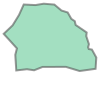

In [10]:
bound = aoi.geometry.iloc[0]
bound # Check that it's shaped like Senegal & Gambia.

In [12]:
aoi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
gDrive = ox.graph_from_polygon(bound, network_type= 'drive', simplify=False, clean_periphery=False)
# Note: length is measured in meters.
# Took approximately 30 min.

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


In [14]:
node_drive = gn.node_gdf_from_graph(gDrive)
node_drive.to_csv(os.path.join(out_pth, 'node_drive_unclean.csv'))

In [15]:
gn.example_edge(gDrive, 2)

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832})


#### Convert the graph to time, then save to file. Edges contain the time measure.

In [17]:
G_edges_drive = gn.edge_gdf_from_graph(gDrive)

In [18]:
G_nodes_drive = gn.node_gdf_from_graph(gDrive)

In [19]:
print(G_edges_drive.info()) # 4,012,565
print(G_nodes_drive.info()) # 1,829,568

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4012565 entries, 0 to 4012564
Data columns (total 17 columns):
 #   Column    Dtype   
---  ------    -----   
 0   stnode    int64   
 1   endnode   int64   
 2   name      object  
 3   oneway    bool    
 4   ref       object  
 5   maxspeed  object  
 6   highway   object  
 7   lanes     object  
 8   tunnel    object  
 9   bridge    object  
 10  width     object  
 11  junction  object  
 12  access    object  
 13  area      object  
 14  length    float64 
 15  osmid     int64   
 16  geometry  geometry
dtypes: bool(1), float64(1), geometry(1), int64(3), object(11)
memory usage: 493.6+ MB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1829568 entries, 0 to 1829567
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   node_ID   int64   
 1   y         float64 
 2   highway   object  
 3   x         float64 
 4   ref       object  
 5   geometry  geometry
dtypes: float64(2),

In [20]:
print(len(G_edges_drive.loc[G_edges_drive['osmid']==0]), end="\n")
print(len(G_edges_drive.loc[G_edges_drive['osmid'].isnull()]))

0
0


In [21]:
speed_dict = {
                'residential': 40,  # kmph
                'primary': 80, 
                'primary_link':60,
                'trunk': 80,
                'trunk_link':60,
                'secondary': 70, 
                'secondary_link':50,
                'service': 40,
                'tertiary':60,
                'tertiary_link': 40,
                'unclassified':50, 
                'road':50,
                'track':25,
                'path':4.5,
                }

In [22]:
gTime = gn.convert_network_to_time(gDrive, distance_tag = 'length', graph_type='drive', speed_dict = speed_dict)
# Note: time is in seconds.

Compare the roads before and after converting to time to make sure the time looks accurate.

In [23]:
print("No time variable\n")
print(gn.example_edge(gDrive, 2))
print("Time variable\n") 
print(gn.example_edge(gTime, 2))

No time variable

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832})
None
Time variable

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127, 'time': 2.3851440000000004, 'mode': 'drive'})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832, 'time': 0.76992, 'mode': 'drive'})
None


In [25]:
edges = gn.edge_gdf_from_graph(gTime) # 4,012,565 edges
nodes = gn.node_gdf_from_graph(gTime) # 1,829,568 nodes. 
print(edges.info(), end="\n")
print(nodes.info()) 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4012565 entries, 0 to 4012564
Data columns (total 19 columns):
 #   Column    Dtype   
---  ------    -----   
 0   stnode    int64   
 1   endnode   int64   
 2   name      object  
 3   oneway    bool    
 4   ref       object  
 5   time      float64 
 6   maxspeed  object  
 7   highway   object  
 8   lanes     object  
 9   mode      object  
 10  tunnel    object  
 11  bridge    object  
 12  width     object  
 13  junction  object  
 14  access    object  
 15  area      object  
 16  length    float64 
 17  osmid     int64   
 18  geometry  geometry
dtypes: bool(1), float64(2), geometry(1), int64(3), object(12)
memory usage: 554.9+ MB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1829568 entries, 0 to 1829567
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   node_ID   int64   
 1   y         float64 
 2   highway   object  
 3   x         float64 
 4   ref       obje

In [26]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
# Save a pickle of the graph and csvs of the edges and nodes with the time measure for easy recall.
gn.save(gTime, 'SEN-Cdrive/gTime', '', edges = True, nodes = True)

### Origins and destinations

Measure distance from origin/destination to nearest node and save to file.

In [9]:
#%% If starting new session, reload graph from file
gTime = nx.read_gpickle("SEN-Cdrive/gTime.pickle")

In [28]:
HDurban_pt = gpd.read_file("SEN-Cdrive/outputs/HDurban_pt.shp")
hamlet_pt = gpd.read_file("SEN-Cdrive/outputs/hamlet_pt.shp")
HDurban_pt = HDurban_pt.to_crs("EPSG:4326")
hamlet_pt = hamlet_pt.to_crs("EPSG:4326")
print(HDurban_pt.info())
print("\n\n")
print(hamlet_pt.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed_ 0  58 non-null     int64   
 1   mgrs_code   58 non-null     object  
 2   type        58 non-null     object  
 3   AREA_GEO    58 non-null     float64 
 4   SUM         58 non-null     float64 
 5   Total_Driv  57 non-null     float64 
 6   WP_dens     58 non-null     float64 
 7   urb         58 non-null     int64   
 8   hd_urb      58 non-null     int64   
 9   Urb_class   58 non-null     int64   
 10  Shape_Leng  58 non-null     float64 
 11  Shape_Area  58 non-null     float64 
 12  geometry    58 non-null     geometry
dtypes: float64(6), geometry(1), int64(4), object(2)
memory usage: 6.0+ KB
None



<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125886 entries, 0 to 125885
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------    

In [29]:
# While we wait for SPAM and landcover joining process, we can still snap land cover points to the network.
agriculture = gpd.read_file("SEN-Cdrive/land cover/LC_value/LC_value.shp") 
agriculture = agriculture.to_crs('EPSG:4326')
agriculture.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6852701 entries, 0 to 6852700
Data columns (total 3 columns):
 #   Column    Dtype   
---  ------    -----   
 0   ID        int64   
 1   LC_90m    int64   
 2   geometry  geometry
dtypes: geometry(1), int64(2)
memory usage: 156.8 MB


In [35]:
?gn.pandana_snap_c

In [30]:
HDurban_snap = gn.pandana_snap_c(gTime, HDurban_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
HDurban_snap.to_csv('SEN-Cdrive/outputs/HDurban_snap.csv', index=True)
HDurban_snap
# The NN_dist is in seconds and should be very short for HDurban since they are all on the road network.

,Unnamed_ 0,mgrs_code,type,AREA_GEO,SUM,Total_Driv,WP_dens,urb,hd_urb,Urb_class,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,POINT (-16.27319 12.56237),6058226279,2.216606
1,8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,POINT (-14.93619 12.89216),6029307183,45.594167
2,37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,POINT (-16.98703 14.44528),4998093094,55.383696
3,47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,POINT (-16.07613 14.16038),2201506815,55.754910
4,56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,POINT (-15.54760 14.10042),3474499811,66.927870
5,75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,POINT (-16.92615 14.78062),1697006012,23.047883
6,76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,POINT (-17.35639 14.75196),1901689169,5.826006
7,80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,POINT (-16.81721 14.94581),6032060028,88.156089
8,84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,POINT (-16.22779 14.65372),6040927878,41.930884
9,98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,POINT (-15.88776 14.86030),3449495495,28.431974


In [31]:
hamlet_snap = gn.pandana_snap_c(gTime, hamlet_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
hamlet_snap.to_csv('SEN-Cdrive/outputs/hamlet_snap.csv', index=True)
hamlet_snap

,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.72147 12.34864),7761872870,307.058089
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.71646 12.34789),7761872869,801.450257
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.71386 12.35088),6442044321,694.273717
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.70128 12.35559),2142496418,689.246791
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.69877 12.35680),2142496429,607.912599
...,...,...,...,...,...,...,...,...,...
125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,POINT (-14.39783 16.39414),8592243241,5089.086102
125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,POINT (-14.39747 16.40568),6375187769,3949.180081
125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,POINT (-14.40036 16.40430),8592243457,4008.851333
125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,POINT (-14.39624 16.49715),3646207611,1826.174300


In [32]:
ag_snap = gn.pandana_snap_c(gTime, agriculture, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
ag_snap.to_csv('SEN-Cdrive/outputs/ag_snap.csv', index=True)
ag_snap

,ID,LC_90m,geometry,NN,NN_dist
0,17,1700,POINT (-15.54997 16.69344),3656617769,6542.678694
1,18,1700,POINT (-15.54916 16.69344),3656617769,6511.929511
2,19,1700,POINT (-15.54836 16.69344),3656617769,6482.181173
3,20,1700,POINT (-15.54755 16.69344),3656617769,6453.447521
4,21,1700,POINT (-15.54674 16.69344),3656617804,6425.455616
...,...,...,...,...,...
6852696,7090377,1700,POINT (-13.00001 12.30741),4618077945,887.864052
6852697,7090378,1700,POINT (-12.99112 12.30741),4618077951,1645.424404
6852698,7090379,1700,POINT (-12.85610 12.30741),4818730342,2863.665090
6852699,7090380,1700,POINT (-12.29583 12.30741),2461705282,104.777301


### Create travel time values for the road nodes nearest to each service.

Using calculate_OD.

In [ ]:
# If starting a new session, load from file.
HDurban_snap = os.path.join(out_pth, "HDurban_snap.csv")
HDurban_snap = pd.read_csv(HDurban_snap)
hamlet_snap = os.path.join(out_pth, "hamlet_snap.csv")
hamlet_snap = pd.read_csv(hamlet_snap)
ag_snap = os.path.join(out_pth, "ag_snap.csv")
ag_snap = pd.read_csv(ag_snap)
gTime = nx.read_gpickle("SEN-Cdrive/outputs/gTime.pickle")

In [39]:
nodes.rename(columns={'node_ID': 'NN'}, inplace=True)

In [29]:
HDurban_snap

,Unnamed_ 0,mgrs_code,type,AREA_GEO,SUM,Total_Driv,WP_dens,urb,hd_urb,Urb_class,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,POINT (-16.27319 12.56237),241852,39.014876
1,8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,POINT (-14.93619 12.89216),503579,120.100715
2,37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,POINT (-16.98703 14.44528),107785,55.383696
3,47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,POINT (-16.07613 14.16038),136007,55.754910
4,56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,POINT (-15.54760 14.10042),82135,66.927870
5,75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,POINT (-16.92615 14.78062),532777,23.047883
6,76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,POINT (-17.35639 14.75196),530867,5.826006
7,80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,POINT (-16.81721 14.94581),152876,89.256124
8,84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,POINT (-16.22779 14.65372),128355,41.930884
9,98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,POINT (-15.88776 14.86030),388971,28.431974


In [33]:
# We only need to find the origin-destination pairs for nodes closest to the origins and services,
# and some nodes will be the nearest for more than one service (and definitely for multiple origins).
list_hamlet = list(hamlet_snap.NN.unique())
origins = list_hamlet

In [34]:
list_ag = list(ag_snap.NN.unique())
originslist = list_hamlet + list_ag
origins = list(set(originslist))

In [41]:
# Alternatively, we can try to run it with all possible road nodes. But that's likely too large.
nodes_list = list(nodes.NN)
len(nodes.NN)

650925

In [35]:
dests = list(HDurban_snap.NN.unique()) 

In [36]:
len(origins) # 554159 unique nearest nodes.

554159

In [37]:
len(dests) # 58 unique nearest nodes. 

58

In [39]:
gn.example_edge(gTime,10)

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127, 'time': 2.3851440000000004, 'mode': 'drive'})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832, 'time': 0.76992, 'mode': 'drive'})
(358284990, 5329792467, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 48.781, 'time': 2.92686, 'mode': 'drive'})
(358284993, 1888282575, {'osmid': 178470940, 'highway': 'tertiary', 'oneway': False, 'length': 126.577, 'time': 7.59462, 'mode': 'drive'})
(358284993, 1888198886, {'osmid': 178470940, 'highway': 'tertiary', 'oneway': False, 'length': 120.578, 'time': 7.23468, 'mode': 'drive'})
(358284994, 6424643487, {'osmid': 178470940, 'highway': 'tertiary', 'oneway': False, 'length': 46.582, 'time': 2.79492, 'mode': 'drive'})
(358284994, 1888282618, {'osmid': 178470940, 'highway': 'tertiary', 'oneway': False, 'length': 53.36, 'time': 3.2016, 'mode

calculate_OD won't run if any of the edge times are null or zero. I think in this case it's edges that are so short that the time was very close to zero but still positive. So we'll reassign time values for those edges to a very small time. A more efficient way to do this would be to simplify junctions with the clean_network() tool, but that was throwing errors.

In [40]:
G_edges = gn.edge_gdf_from_graph(gTime)
len(G_edges.loc[G_edges['time'].isnull()])

0

In [41]:
len(G_edges.loc[G_edges['time']==0]) 

0

In [38]:
fail_value = 999999999 # If there is no shortest path, the OD pair will be assigned the fail value.

In [42]:
OD = gn.calculate_OD(gTime, origins, dests, fail_value, weight = 'time')
# Takes a few minutes.

In [69]:
# Let's also do a version from agriculture to the nearest hamlet.
OD_agham = gn.calculate_OD(gTime, list_ag, list_hamlet, fail_value, weight = 'time')

MemoryError: Unable to allocate 247. GiB for an array with shape (61230, 541461) and data type float64

In [43]:
OD_df = pd.DataFrame(OD, index = origins, columns = dests)

In [ ]:
OD_agham = pd.DataFrame(OD_agham, index = list_ag, columns = list_hamlet)
OD_agham.info()

In [44]:
OD_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554159 entries, 5755633676 to 6024069080
Data columns (total 58 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   6058226279  554159 non-null  float64
 1   6029307183  554159 non-null  float64
 2   4998093094  554159 non-null  float64
 3   2201506815  554159 non-null  float64
 4   3474499811  554159 non-null  float64
 5   1697006012  554159 non-null  float64
 6   1901689169  554159 non-null  float64
 7   6032060028  554159 non-null  float64
 8   6040927878  554159 non-null  float64
 9   3449495495  554159 non-null  float64
 10  3990543961  554159 non-null  float64
 11  8972391475  554159 non-null  float64
 12  3418418812  554159 non-null  float64
 13  1983641803  554159 non-null  float64
 14  6014451367  554159 non-null  float64
 15  6027163276  554159 non-null  float64
 16  2833577858  554159 non-null  float64
 17  4656728818  554159 non-null  float64
 18  6045659373  554159 non-null  fl

In [45]:
OD_df.tail()

,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
3766810947,19160.356536,10793.792415,25124.984374,20212.199145,17372.651445,26559.935661,27873.615501,26845.983628,23107.279635,23272.886181,...,28819.431286,32150.211887,7994.682147,8016.132042,25384.977455,27684.045213,27739.149855,28049.852697,23487.561772,23800.019966
6024069077,15744.801209,14664.857321,4235.250954,4190.173813,6944.589305,2575.171888,4935.757834,2861.219855,1294.798303,3364.436960,...,6272.216115,9435.107981,16323.784862,16574.331392,4495.244035,4647.956153,4616.260320,4611.007931,3231.825021,3953.397348
6024069078,15743.337305,14663.393417,4233.787050,4188.709909,6943.125401,2573.707984,4934.293930,2859.755951,1293.334399,3362.973056,...,6270.752211,9433.644077,16322.320958,16572.867488,4493.780131,4646.492249,4614.796416,4609.544027,3230.361117,3951.933444
6024069079,15736.563617,14656.619729,4227.013362,4181.936221,6936.351713,2566.934296,4927.520242,2852.982263,1286.560711,3356.199368,...,6263.978523,9426.870389,16315.547270,16566.093800,4487.006443,4639.718561,4608.022728,4602.770339,3223.587429,3945.159756
6024069080,15725.588369,14645.644481,4216.038114,4170.960973,6925.376465,2555.959048,4916.544994,2842.007015,1275.585463,3345.224120,...,6253.003275,9415.895141,16304.572022,16555.118552,4476.031195,4628.743313,4597.047480,4591.795091,3212.612181,3934.184508


In [47]:
# Convert to minutes and save to file.
OD_min = OD_df[OD_df <fail_value] / 60
OD_min.to_csv(os.path.join(out_pth, 'OD_allorigins.csv'))
OD_min

,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
5755633676,140.544754,122.545690,142.612543,60.732789,63.218641,166.528398,188.423062,171.295864,108.984131,142.684589,...,229.578295,282.293159,195.557939,199.733714,146.945761,185.263557,186.181968,191.360348,140.474390,152.500595
5755633677,140.572644,122.573579,142.640432,60.760678,63.246531,166.556287,188.450951,171.323753,109.012020,142.712478,...,229.606184,282.321048,195.585828,199.761603,146.973650,185.291446,186.209857,191.388238,140.502279,152.528485
5755633678,140.624876,122.625811,142.692665,60.812911,63.298763,166.608519,188.503183,171.375985,109.064252,142.764711,...,229.658416,282.373281,195.638060,199.813836,147.025883,185.343679,186.262089,191.440470,140.554512,152.580717
5755633680,140.673033,122.673968,142.740822,60.861068,63.346920,166.656677,188.551341,171.424143,109.112409,142.812868,...,229.706573,282.421438,195.686217,199.861993,147.074040,185.391836,186.310246,191.488627,140.602669,152.628874
5755633681,140.726353,122.727288,142.794141,60.914388,63.400240,166.709996,188.604660,171.477462,109.165729,142.866187,...,229.759893,282.474758,195.739537,199.915312,147.127359,185.445155,186.363566,191.541947,140.655988,152.682194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766810947,319.339276,179.896540,418.749740,336.869986,289.544191,442.665594,464.560258,447.433060,385.121327,387.881436,...,480.323855,535.836865,133.244702,133.602201,423.082958,461.400754,462.319164,467.497545,391.459363,396.666999
6024069077,262.413353,244.414289,70.587516,69.836230,115.743155,42.919531,82.262631,47.686998,21.579972,56.073949,...,104.536935,157.251800,272.063081,276.238857,74.920734,77.465936,76.937672,76.850132,53.863750,65.889956
6024069078,262.388955,244.389890,70.563117,69.811832,115.718757,42.895133,82.238232,47.662599,21.555573,56.049551,...,104.512537,157.227401,272.038683,276.214458,74.896336,77.441537,76.913274,76.825734,53.839352,65.865557
6024069079,262.276060,244.276995,70.450223,69.698937,115.605862,42.782238,82.125337,47.549704,21.442679,55.936656,...,104.399642,157.114506,271.925788,276.101563,74.783441,77.328643,76.800379,76.712839,53.726457,65.752663


In [ ]:
OD_agham = OD_ag-ham[OD_ag-ham <fail_value] / 60
OD_agham.to_csv(os.path.join(out_pth, 'OD_ag-to-hamlet.csv'))
OD_agham

In [48]:
print(OD_min.isna().sum())

6058226279    8
6029307183    8
4998093094    8
2201506815    8
3474499811    8
1697006012    8
1901689169    8
6032060028    8
6040927878    8
3449495495    8
3990543961    8
8972391475    8
3418418812    8
1983641803    8
6014451367    8
6027163276    8
2833577858    8
4656728818    8
6045659373    8
5528866190    8
6027939517    8
6031093257    8
1883155712    8
6026417971    8
6031245697    8
7493947593    8
1859359090    8
6053816462    8
6027530676    8
2988435647    8
1332801944    8
6053825179    8
2988435792    8
3036877534    8
6056472223    8
7460241128    8
6028595154    8
4053739078    8
4071261250    8
6014815762    8
6024430122    8
8229317581    8
6027834438    8
6024894515    8
6024894530    8
6024894513    8
6031993937    8
8200298999    8
1968458114    8
1936967272    8
3496518021    8
6027615161    8
6027276892    8
6041228287    8
5536661253    8
7357630367    8
8178147277    8
6026834850    8
dtype: int64


In [ ]:
print(OD_agham.isna().sum())

In [49]:
# Factor of 1000
OD_hamlet = OD_df.loc[list_hamlet,:]
OD_hamlet = OD_hamlet[OD_hamlet < fail_value] / 60 
OD_hamlet.to_csv(os.path.join(out_pth, 'OD_hamlet.csv'))
OD_hamlet

,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
7761872870,62.539942,199.574127,334.953844,253.074090,255.559942,358.869698,380.764362,363.637164,301.325431,335.025890,...,421.919595,474.634460,360.925876,361.283375,339.287062,377.604858,378.523268,383.701649,332.815691,344.841896
7761872869,62.521382,199.555567,334.935284,253.055530,255.541383,358.851139,380.745803,363.618605,301.306872,335.007330,...,421.901036,474.615900,360.907317,361.264815,339.268502,377.586298,378.504709,383.683089,332.797131,344.823337
6442044321,61.511550,198.545735,333.925452,252.045698,254.531551,357.841307,379.735971,362.608773,300.297040,333.997498,...,420.891204,473.606068,359.897485,360.254983,338.258670,376.576466,377.494877,382.673257,331.787299,343.813505
2142496418,62.965072,199.999257,335.378974,253.499220,255.985073,359.294829,381.189493,364.062295,301.750562,335.451020,...,422.344726,475.059590,361.351007,361.708505,339.712192,378.029988,378.948399,384.126779,333.240821,345.267027
2142496429,63.347446,200.381631,335.761348,253.881594,256.367447,359.677203,381.571867,364.444669,302.132936,335.833394,...,422.727100,475.441964,361.733381,362.090879,340.094566,378.412362,379.330773,384.509153,333.623195,345.649401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9207762346,533.503065,497.561040,378.761277,339.623942,355.382987,351.093292,390.436391,354.174342,292.615922,258.023359,...,280.170025,242.196268,343.082181,342.724169,383.094495,385.639697,385.111433,385.023893,267.313841,260.404815
8463584916,440.574927,422.575862,214.404399,246.695804,265.075194,178.977470,217.301017,162.046033,199.687784,167.454534,...,90.272091,64.552430,420.914505,425.090280,215.921137,212.504322,211.976058,211.888519,169.499311,170.561891
8463593882,444.334132,426.335068,218.372608,250.455009,268.834400,182.945679,221.269226,166.014242,203.446989,171.213740,...,94.031296,59.028425,424.673710,428.849485,219.889346,216.472532,215.944268,215.856728,173.258516,174.321097
9208004175,616.957292,598.958227,385.081263,424.380169,448.130931,349.654334,387.977881,332.722897,376.123910,350.510271,...,263.232996,202.558740,603.970241,608.146017,386.598001,383.181186,382.652922,382.565383,352.555048,353.617628


In [50]:
print(OD_hamlet.isna().sum())

6058226279    3
6029307183    3
4998093094    3
2201506815    3
3474499811    3
1697006012    3
1901689169    3
6032060028    3
6040927878    3
3449495495    3
3990543961    3
8972391475    3
3418418812    3
1983641803    3
6014451367    3
6027163276    3
2833577858    3
4656728818    3
6045659373    3
5528866190    3
6027939517    3
6031093257    3
1883155712    3
6026417971    3
6031245697    3
7493947593    3
1859359090    3
6053816462    3
6027530676    3
2988435647    3
1332801944    3
6053825179    3
2988435792    3
3036877534    3
6056472223    3
7460241128    3
6028595154    3
4053739078    3
4071261250    3
6014815762    3
6024430122    3
8229317581    3
6027834438    3
6024894515    3
6024894530    3
6024894513    3
6031993937    3
8200298999    3
1968458114    3
1936967272    3
3496518021    3
6027615161    3
6027276892    3
6041228287    3
5536661253    3
7357630367    3
8178147277    3
6026834850    3
dtype: int64


In [51]:
# Create origin-specific matrix and save to file.
OD_ag = OD_df.loc[list_ag,:]
OD_ag = OD_ag[OD_ag < fail_value] / 60 
OD_ag.to_csv(os.path.join(out_pth, 'OD_ag.csv'))
OD_ag

,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
3656617769,578.309363,560.310299,346.433334,385.732240,409.483002,311.006405,349.329952,294.074969,337.475982,311.862343,...,224.585067,163.910812,565.322313,569.498088,347.950072,344.533258,344.004994,343.917454,313.907119,314.969699
3656617804,578.333584,560.334520,346.457555,385.756461,409.507223,311.030626,349.354173,294.099190,337.500203,311.886564,...,224.609288,163.935033,565.346534,569.522309,347.974293,344.557479,344.029215,343.941675,313.931340,314.993920
3656618066,578.419408,560.420344,346.543379,385.842285,409.593047,311.116450,349.439997,294.185014,337.586027,311.972388,...,224.695112,164.020857,565.432358,569.608133,348.060117,344.643303,344.115039,344.027499,314.017164,315.079744
9208195325,594.009436,576.010371,362.133407,401.432313,425.183075,326.706477,365.030025,309.775041,353.176054,327.562415,...,240.285139,179.610884,581.022385,585.198161,363.650144,360.233330,359.705066,359.617526,329.607192,330.669772
9208195303,598.310662,580.311597,366.434633,405.733539,429.484301,331.007703,369.331251,314.076267,357.477280,331.863641,...,244.586365,183.912110,585.323611,589.499387,367.951370,364.534556,364.006292,363.918752,333.908418,334.970998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8585063327,151.667751,105.395599,363.306894,281.427140,283.912992,387.222749,409.117413,391.990215,329.678482,363.378940,...,450.272646,502.987510,266.747349,267.104847,367.640112,405.957908,406.876319,412.054699,361.168741,373.194946
8585142396,174.141696,87.553033,345.464328,263.584574,266.070427,369.380183,391.274847,374.147649,311.835916,345.536374,...,432.430080,485.144944,235.693913,236.051411,349.797546,388.115342,389.033753,394.212134,343.326175,355.352381
4618077944,388.558907,249.116172,487.969371,406.089618,358.763823,511.885226,533.779890,516.652692,454.340959,457.101068,...,549.543487,605.056497,202.464334,202.821832,492.302589,530.620385,531.538796,536.717177,460.678995,465.886631
4618077951,387.953467,248.510731,487.363931,405.484177,358.158382,511.279785,533.174449,516.047251,453.735518,456.495627,...,548.938046,604.451056,201.858893,202.216392,491.697149,530.014945,530.933355,536.111736,460.073554,465.281190


In [52]:
print(OD_ag.isna().sum())

6058226279    8
6029307183    8
4998093094    8
2201506815    8
3474499811    8
1697006012    8
1901689169    8
6032060028    8
6040927878    8
3449495495    8
3990543961    8
8972391475    8
3418418812    8
1983641803    8
6014451367    8
6027163276    8
2833577858    8
4656728818    8
6045659373    8
5528866190    8
6027939517    8
6031093257    8
1883155712    8
6026417971    8
6031245697    8
7493947593    8
1859359090    8
6053816462    8
6027530676    8
2988435647    8
1332801944    8
6053825179    8
2988435792    8
3036877534    8
6056472223    8
7460241128    8
6028595154    8
4053739078    8
4071261250    8
6014815762    8
6024430122    8
8229317581    8
6027834438    8
6024894515    8
6024894530    8
6024894513    8
6031993937    8
8200298999    8
1968458114    8
1936967272    8
3496518021    8
6027615161    8
6027276892    8
6041228287    8
5536661253    8
7357630367    8
8178147277    8
6026834850    8
dtype: int64


### Filter 1st nearest

#### Check each file to make sure nearest neighbor column is named correctly. If not, rename.

In [53]:
# Reload from file even if already loaded. Quickest way to ensure NN is a column rather than only the index.
OD_hamlet = os.path.join(out_pth, "OD_hamlet.csv")
OD_hamlet = pd.read_csv(OD_hamlet)

In [54]:
OD_ag = os.path.join(out_pth, "OD_ag.csv")
OD_ag = pd.read_csv(OD_ag)

In [ ]:
OD_agham = os.path.join(out_pth, "OD_ag-to-hamlet.csv")
OD_agham = pd.read_csv(OD_agham)

In [57]:
OD_ag.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) 

In [58]:
OD_hamlet.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) 

In [ ]:
OD_agham.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) 

In [59]:
OD_ag

,NN,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
0,3656617769,578.309363,560.310299,346.433334,385.732240,409.483002,311.006405,349.329952,294.074969,337.475982,...,224.585067,163.910812,565.322313,569.498088,347.950072,344.533258,344.004994,343.917454,313.907119,314.969699
1,3656617804,578.333584,560.334520,346.457555,385.756461,409.507223,311.030626,349.354173,294.099190,337.500203,...,224.609288,163.935033,565.346534,569.522309,347.974293,344.557479,344.029215,343.941675,313.931340,314.993920
2,3656618066,578.419408,560.420344,346.543379,385.842285,409.593047,311.116450,349.439997,294.185014,337.586027,...,224.695112,164.020857,565.432358,569.608133,348.060117,344.643303,344.115039,344.027499,314.017164,315.079744
3,9208195325,594.009436,576.010371,362.133407,401.432313,425.183075,326.706477,365.030025,309.775041,353.176054,...,240.285139,179.610884,581.022385,585.198161,363.650144,360.233330,359.705066,359.617526,329.607192,330.669772
4,9208195303,598.310662,580.311597,366.434633,405.733539,429.484301,331.007703,369.331251,314.076267,357.477280,...,244.586365,183.912110,585.323611,589.499387,367.951370,364.534556,364.006292,363.918752,333.908418,334.970998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541456,8585063327,151.667751,105.395599,363.306894,281.427140,283.912992,387.222749,409.117413,391.990215,329.678482,...,450.272646,502.987510,266.747349,267.104847,367.640112,405.957908,406.876319,412.054699,361.168741,373.194946
541457,8585142396,174.141696,87.553033,345.464328,263.584574,266.070427,369.380183,391.274847,374.147649,311.835916,...,432.430080,485.144944,235.693913,236.051411,349.797546,388.115342,389.033753,394.212134,343.326175,355.352381
541458,4618077944,388.558907,249.116172,487.969371,406.089618,358.763823,511.885226,533.779890,516.652692,454.340959,...,549.543487,605.056497,202.464334,202.821832,492.302589,530.620385,531.538796,536.717177,460.678995,465.886631
541459,4618077951,387.953467,248.510731,487.363931,405.484177,358.158382,511.279785,533.174449,516.047251,453.735518,...,548.938046,604.451056,201.858893,202.216392,491.697149,530.014945,530.933355,536.111736,460.073554,465.281190


In [60]:
OD_hamlet

,NN,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
0,7761872870,62.539942,199.574127,334.953844,253.074090,255.559942,358.869698,380.764362,363.637164,301.325431,...,421.919595,474.634460,360.925876,361.283375,339.287062,377.604858,378.523268,383.701649,332.815691,344.841896
1,7761872869,62.521382,199.555567,334.935284,253.055530,255.541383,358.851139,380.745803,363.618605,301.306872,...,421.901036,474.615900,360.907317,361.264815,339.268502,377.586298,378.504709,383.683089,332.797131,344.823337
2,6442044321,61.511550,198.545735,333.925452,252.045698,254.531551,357.841307,379.735971,362.608773,300.297040,...,420.891204,473.606068,359.897485,360.254983,338.258670,376.576466,377.494877,382.673257,331.787299,343.813505
3,2142496418,62.965072,199.999257,335.378974,253.499220,255.985073,359.294829,381.189493,364.062295,301.750562,...,422.344726,475.059590,361.351007,361.708505,339.712192,378.029988,378.948399,384.126779,333.240821,345.267027
4,2142496429,63.347446,200.381631,335.761348,253.881594,256.367447,359.677203,381.571867,364.444669,302.132936,...,422.727100,475.441964,361.733381,362.090879,340.094566,378.412362,379.330773,384.509153,333.623195,345.649401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61225,9207762346,533.503065,497.561040,378.761277,339.623942,355.382987,351.093292,390.436391,354.174342,292.615922,...,280.170025,242.196268,343.082181,342.724169,383.094495,385.639697,385.111433,385.023893,267.313841,260.404815
61226,8463584916,440.574927,422.575862,214.404399,246.695804,265.075194,178.977470,217.301017,162.046033,199.687784,...,90.272091,64.552430,420.914505,425.090280,215.921137,212.504322,211.976058,211.888519,169.499311,170.561891
61227,8463593882,444.334132,426.335068,218.372608,250.455009,268.834400,182.945679,221.269226,166.014242,203.446989,...,94.031296,59.028425,424.673710,428.849485,219.889346,216.472532,215.944268,215.856728,173.258516,174.321097
61228,9208004175,616.957292,598.958227,385.081263,424.380169,448.130931,349.654334,387.977881,332.722897,376.123910,...,263.232996,202.558740,603.970241,608.146017,386.598001,383.181186,382.652922,382.565383,352.555048,353.617628


In [70]:
OD_agham

NameError: name 'OD_agham' is not defined

#### Find first, second, and third nearest destination for each origin node. 

In [61]:
fail_value = 999999999

In [62]:
# Nearest
OD_ag["ag_HD1"] = 0
sub = OD_ag.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_ag["ag_HD1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
ag1 = OD_ag[['NN', 'ag_HD1']] # Remove unnecessary OD values.


# Second nearest
dupes = OD_ag.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_ag.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.
OD_ag["ag_HD2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_ag["ag_HD2"] = Dsub.min(axis=1) 
ag2 = OD_ag.loc[:,['NN', 'ag_HD2']] 


# Third nearest
dupes = OD_ag.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_ag.where(~dupes, fail_value)

OD_ag["ag_HD3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_ag["ag_HD3"] = Dsub.min(axis=1)
ag3 = OD_ag.loc[:,['NN', 'ag_HD3']]

# Combine and write to file
ag_all = OD_ag.loc[:,['NN', 'ag_HD1', 'ag_HD2', 'ag_HD3']]
ag_all.to_csv(os.path.join(out_pth, 'ag_to_HDurban.csv'))
ag_all.head()

,NN,ag_HD1,ag_HD2,ag_HD3
0,3656617769,163.910812,164.865095,170.548642
1,3656617804,163.935033,164.889316,170.572863
2,3656618066,164.020857,164.975140,170.658687
3,9208195325,179.610884,180.565168,186.248715
4,9208195303,183.912110,184.866393,190.549941


In [63]:
# Nearest
OD_hamlet["ha_HD1"] = 0
sub = OD_hamlet.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_hamlet["ha_HD1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
hamlet1 = OD_hamlet[['NN', 'ha_HD1']] # Remove unnecessary OD values.


# Second nearest
dupes = OD_hamlet.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_hamlet.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.
OD_hamlet["ha_HD2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_hamlet["ha_HD2"] = Dsub.min(axis=1) 
hamlet2 = OD_hamlet.loc[:,['NN', 'ha_HD2']] 


# Third nearest
dupes = OD_hamlet.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_hamlet.where(~dupes, fail_value)
OD_hamlet["ha_HD3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_hamlet["ha_HD3"] = Dsub.min(axis=1)
hamlet3 = OD_hamlet.loc[:,['NN', 'ha_HD3']]


# Combine and write to file
hamlet_all = OD_hamlet.loc[:,['NN', 'ha_HD1', 'ha_HD2', 'ha_HD3']]
hamlet_all.to_csv(os.path.join(out_pth, 'hamlet_to_HDurban.csv'))
hamlet_all.head()

,NN,ha_HD1,ha_HD2,ha_HD3
0,7761872870,62.539942,65.908250,199.574127
1,7761872869,62.521382,65.889691,199.555567
2,6442044321,61.511550,64.879859,198.545735
3,2142496418,62.965072,66.333381,199.999257
4,2142496429,63.347446,66.715755,200.381631


In [ ]:
# Nearest
OD_agham["agham1"] = 0
sub = OD_agham.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_agham["agham1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
agham1 = OD_agham[['NN', 'agham1']] # Remove unnecessary OD values.


# Second nearest
dupes = OD_agham.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_agham.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.
OD_agham["agham2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_agham["agham2"] = Dsub.min(axis=1) 
agham2 = OD_agham.loc[:,['NN', 'agham2']] 


# Third nearest
dupes = OD_agham.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_agham.where(~dupes, fail_value)

OD_agham["agham3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_agham["agham3"] = Dsub.min(axis=1)
agham3 = OD_agham.loc[:,['NN', 'agham3']]

# Combine and write to file
agham_all = OD_agham.loc[:,['NN', 'agham1', 'agham2', 'agham3']]
agham_all.to_csv(os.path.join(out_pth, 'ag_to_hamlet.csv'))
agham_all.head()

### Join back to georeferenced _snap file.

In [ ]:
# If starting new session, reload from file.
ag_all = os.path.join(out_pth, "ag_to_HDurban.csv")
ag_all = pd.read_csv(ag_all)
ag_all.info() # Check to make sure NN data type matches its corresponding _snap file

In [ ]:
hamlet_all = os.path.join(out_pth, "hamlet_to_HDurban.csv")
hamlet_all = pd.read_csv(hamlet_all)
hamlet_all.info()

In [ ]:
ag_snap = os.path.join(out_pth, "ag_snap.csv")
ag_snap = pd.read_csv(ag_snap)
ag_snap.info()

In [ ]:
hamlet_snap = os.path.join(out_pth, "hamlet_snap.csv")
hamlet_snap = pd.read_csv(hamlet_snap)
hamlet_snap.info()

In [64]:
ag_to_HDurban = pd.merge(ag_snap, ag_all, on='NN',how='left')
ag_to_HDurban

,ID,LC_90m,geometry,NN,NN_dist,ag_HD1,ag_HD2,ag_HD3
0,17,1700,POINT (-15.54997 16.69344),3656617769,6542.678694,163.910812,164.865095,170.548642
1,18,1700,POINT (-15.54916 16.69344),3656617769,6511.929511,163.910812,164.865095,170.548642
2,19,1700,POINT (-15.54836 16.69344),3656617769,6482.181173,163.910812,164.865095,170.548642
3,20,1700,POINT (-15.54755 16.69344),3656617769,6453.447521,163.910812,164.865095,170.548642
4,21,1700,POINT (-15.54674 16.69344),3656617804,6425.455616,163.935033,164.889316,170.572863
...,...,...,...,...,...,...,...,...
6852696,7090377,1700,POINT (-13.00001 12.30741),4618077945,887.864052,197.512349,198.701650,202.383349
6852697,7090378,1700,POINT (-12.99112 12.30741),4618077951,1645.424404,196.987894,198.177195,201.858893
6852698,7090379,1700,POINT (-12.85610 12.30741),4818730342,2863.665090,200.190415,201.379716,205.061414
6852699,7090380,1700,POINT (-12.29583 12.30741),2461705282,104.777301,210.874498,212.063799,216.102996


In [65]:
hamlet_to_HDurban = pd.merge(hamlet_snap, hamlet_all, on='NN',how='left')
hamlet_to_HDurban

,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,geometry,NN,NN_dist,ha_HD1,ha_HD2,ha_HD3
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.72147 12.34864),7761872870,307.058089,62.539942,65.908250,199.574127
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.71646 12.34789),7761872869,801.450257,62.521382,65.889691,199.555567
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.71386 12.35088),6442044321,694.273717,61.511550,64.879859,198.545735
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.70128 12.35559),2142496418,689.246791,62.965072,66.333381,199.999257
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.69877 12.35680),2142496429,607.912599,63.347446,66.715755,200.381631
...,...,...,...,...,...,...,...,...,...,...,...,...
125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,POINT (-14.39783 16.39414),8592243241,5089.086102,184.373909,186.462146,192.520965
125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,POINT (-14.39747 16.40568),6375187769,3949.180081,182.444477,184.532714,190.591533
125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,POINT (-14.40036 16.40430),8592243457,4008.851333,184.075151,186.163388,192.222207
125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,POINT (-14.39624 16.49715),3646207611,1826.174300,180.281911,182.370148,188.428967


In [66]:
hamlet_to_HDurban.to_csv(os.path.join(out_pth, 'hamlet_to_HDurban.csv'))

In [67]:
ag_to_HDurban.to_csv(os.path.join(out_pth, 'ag_to_HDurban.csv'))

### End of script. Load into QGIS or Arc and visualize at 10 min intervals. 
QML file for symbology in QGIS:
R:\GEOGlobal\Design\symb_traveltimes_10min.qml